# A modified CenterNet architecture for oriented bounding box detection

See the CenterNet official repo : https://github.com/xingyizhou/CenterNet

The main goal of this repo is to demonstrate how we can adapt the CenterNet ideas to multiple cars from a Bird Eye View as oriented bounding boxes. We train our network to predict a heatmap of the <b>box center</b> that is refined with an <b>offset map</b>. Then <b>bounding boxes dimensions</b> are regressed to get length and width of the vehicle. Orientation angle is also inferred with 2 heatmaps, <b>one for cosine and for sine</b>. In terms of architecture, another difference with CenterNet is that we are not using any upsampling layers, since detection of small objects doesnt require a global information of the original image.

# Summary
- import and display your dataset
- define utility functions to draw heatmaps and how we can recover oriented bounding boxes from main heatmap, offset heatmaps, width and height heatmaps, and sine/cosine heatmaps
- make a Pytorch dataset for training and validation
- define the model with a Resnet-18 backbone
- define our loss
- train the network
- display a few predictions on the validation dataset

# Imports

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim

assert torch.cuda.is_available()

# Not always necessary depending on your hardware/GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [12]:
# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 416
input_height = 416

# Model scale is 16, meaning that in the model prediction, we have heatmaps of dimensions 80 x 45
MODEL_SCALE = 16

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 4

Image i_jpg.rf.5a86e358003406fe01e27331c7749193.jpg


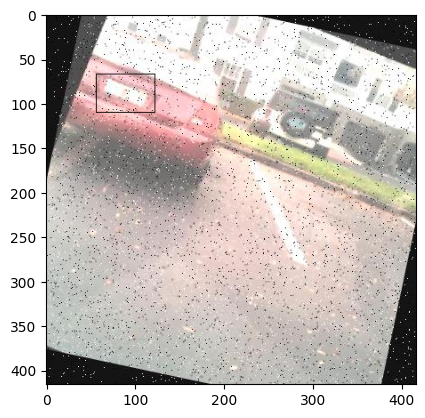

In [16]:
dataset_folder = '/home/rivian/Desktop/Datasets/License Plate Recognition.v6i.tensorflow/'
labels_file = dataset_folder +  "train_annotations.csv"

# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder+"train"))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder+"train", IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Load labels
train_df = pd.read_csv(labels_file)
train_df['x'] = train_df['xmin'].astype(float)
train_df['y'] = train_df['ymin'].astype(float)
train_df['w'] = train_df['xmax'].astype(float) - train_df['xmin'].astype(float)
train_df['h'] = train_df['ymax'].astype(float) - train_df['ymin'].astype(float)
target = train_df[train_df['filename']==IMAGE]
centers = np.array([target["x"], target["y"]]).T
bboxs = target[["x", "y", "w", "h"]].to_numpy().astype(int)
train_df.head()
cv2.rectangle(img,(bboxs[0][0],bboxs[0][1]),(bboxs[0][0]+bboxs[0][2],bboxs[0][1]+bboxs[0][3]),2)
plt.imshow(img)

# Load dataset

dataset_folder = '/home/ai/Desktop/Datasets/box_4corner_img/'
labels_file = dataset_folder +  "labels.csv"

# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder+"train"))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder+"train", IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Load labels
train_df = pd.read_csv(labels_file)
train_df['x'] = train_df['x'].astype(float)
train_df['y'] = train_df['y'].astype(float)
train_df['w'] = train_df['w'].astype(float)
train_df['h'] = train_df['l'].astype(float)
train_df['angle'] = train_df['angle'].astype(float)

print(f"Image shape = {img.shape}")

target = train_df[train_df['name']==IMAGE[:-4]]
print(target)

# convert targets to its center.
centers = np.array([target["x"], target["y"]]).T

rotations = []
for angle in target["angle"]:
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotations.append(np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]]))

bboxs = target[["x", "y", "w", "l"]].to_numpy()

for center, rot, box in zip(centers, rotations, bboxs):
    bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    
    br = (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1]))
    tr = (int(center[0]+top_right[0]), int(center[1]+top_right[1]))
    tl = (int(center[0]+top_left[0]), int(center[1]+top_left[1]))
    bl = (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1]))

    thickness = 3
    cv2.line(img, br, tr, (0, 220, 0), thickness)
    cv2.line(img, br, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, tr, (220, 220, 0), thickness)

#plt.figure(figsize=(14,14))
plt.imshow(img)

# Utility functions

Let's plot center points into the image.

In [17]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [18]:
# Heatmap function
# MODEL_SCALE = 16 ==> 1280 to 80, 720 ==> 45
def make_hm_offset_regr_angle(target):
    hm = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    regr = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    #cos_sin_hm = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
     
    if len(target) == 0:
        return hm, offset, regr
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    for i, c in target.iterrows():
        c["x"] = (c["x"] + ( c["x"] + c["w"])) / 2
        c["y"] = (c["y"] + ( c["y"] + c["h"])) / 2
        
        hm = draw_msra_gaussian(hm, [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
                                sigma=1)
        assert 0 <= c["x"] < 416
        assert 0 <= c["y"] < 416
        offset = draw_offset(offset, c["x"]/MODEL_SCALE, c["y"]/MODEL_SCALE)
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                try:
                    regr[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["w"]/MODEL_SCALE
                    regr[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["h"]/MODEL_SCALE
                    #cos_sin_hm[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.cos(c["angle"])
                    #cos_sin_hm[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.sin(c["angle"])
                except:
                    pass
        #angles= target["angle"]
        
                
    #regr[0] = regr[0].T; regr[1] = regr[1].T;
    #angle = angle.T
    return hm, offset, regr #, cos_sin_hm


In [19]:
def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm

In [20]:
def pred2box(hm, offset, regr, thresh=0.5):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    print(pred_r)
    print(regr[:,pred])
    #pred_angles = cos_sin_hm[:, pred].T
    
    #print("pred_angle", pred_angle)

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b) in zip(pred_center, pred_r):
        #print(b)
        offset_xy = offset[:, center[0], center[1]]
        #angle = np.arctan2(pred_angle[1], pred_angle[0])
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0]*MODEL_SCALE, b[1]*MODEL_SCALE])
        # Clip values between 0 and input_size
        #arr = np.clip(arr, 0, input_size)
        #print("Pred angle", i, pred_angle[i])
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores

In [21]:
# functions for plotting results
def showbox(img, hm, offset, regr, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, thresh=thresh)
    
    sample = img

    for box in boxes:
        center = [int(box[0]), int(box[1])] 
        #cos_angle = np.cos(box[4])
        #sin_angle = np.sin(box[4])
        #rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        reg_w = int(box[2]) 
        reg_h = int(box[3])
        print(center)
        
        xmin = center[0] - (reg_w / 2)
        ymin = center[1] - (reg_h / 2)
        xmax = center[0] + (reg_w / 2)
        ymax = center[1] + (reg_h / 2)
        
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)
        
        cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),2)
        # bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        # top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        # thickness = 3
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (0, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (220, 220, 0), thickness)
    return sample


# Make Pytorch dataset with dataloader

In [22]:
# Split train-test by unique image ids, corresponding to image paths
train_id, test_id = train_test_split(sorted(os.listdir(dataset_folder+"train")), test_size=0.2, random_state=777)

In [23]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels, transform=None):
        self.img_id = img_id
        self.labels = labels
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(dataset_folder+"train", self.img_id[idx]))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['filename']==self.img_id[idx]]
        hm, offset, regr = make_hm_offset_regr_angle(target)
        #assert(hm.shape == (128, 128))
        #assert(regr.shape == (2, 128, 128))
        #assert(angle.shape == (128, 128))
        return img, hm, offset, regr


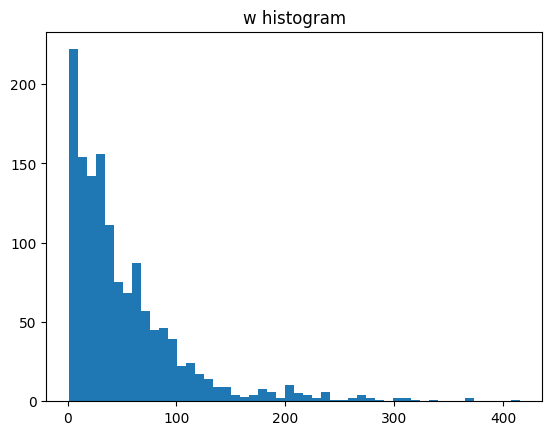

In [24]:
traindataset = CarDataset(train_id, train_df)
valdataset = CarDataset(test_id, train_df)

# Your angle histogram should be as flat as possible to reduce overfitting!
target = train_df["w"]
plt.hist(target, bins=50)
plt.title("w histogram")
plt.show()


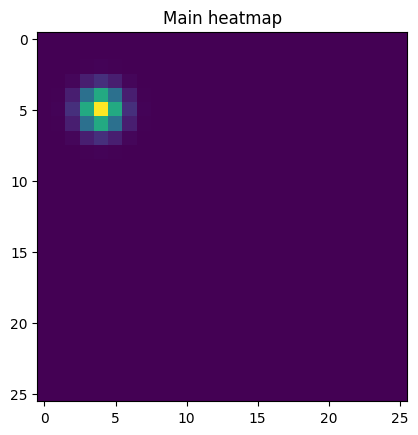

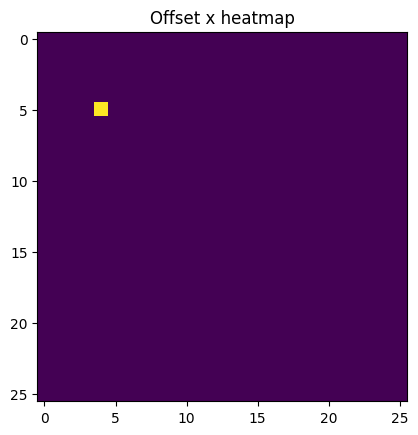

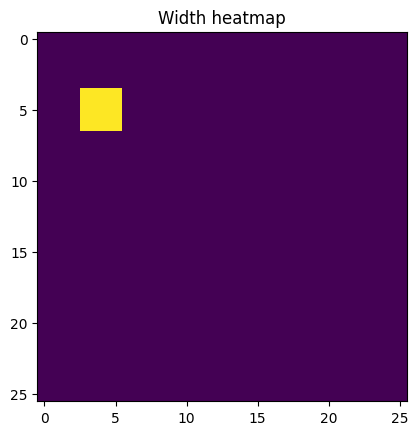

[[3.375 2.625]]
[[3.375]
 [2.625]]
[72, 83]


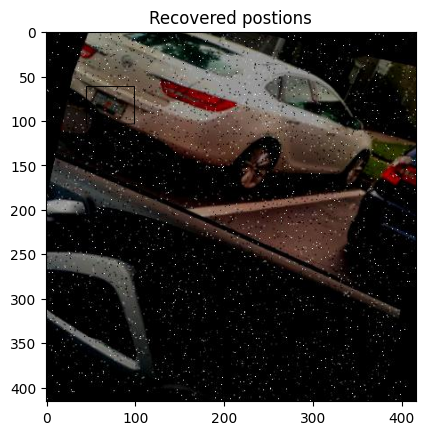

In [25]:
# Check traindataset

k = random.randint(0, len(train_id))
# Test dataset
img, hm, offset, regr = traindataset[k]

plt.imshow(hm)
plt.title("Main heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(os.path.join(dataset_folder+"train", train_id[k]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img,(16,16))
img = showbox(img, hm, offset, regr, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

In [26]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True)

## Define Centernet model

In [27]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        basemodel = torchvision.models.resnet18(pretrained=True)
        
        # DO NOT FREEZE ResNet weights
        #for param in basemodel.parameters():
        #    param.requires_grad = False
        
        # Select only first layers up when you reach 80x45 dimensions with 256 channels
        self.base_model = nn.Sequential(*list(basemodel.children())[:-3])
        
        num_ch = 256
        head_conv = 64
        self.outc = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 1, kernel_size=1, stride=1))
        
        self.outo = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outr = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outa = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
    def forward(self, x):
        # [b, 3, 720, 1280]
        
        x = self.base_model(x)
        # [b, 128, 90, 160] 
        
        assert not torch.isnan(x).any()
        
        outc = self.outc(x) 
        # [b, 1, 90, 160]
        assert not torch.isnan(outc).any()
        
        outo = self.outo(x)
        # [b, 2, 90, 160]
        assert not torch.isnan(outo).any()
        
        outr = self.outr(x)
        #outa = self.outa(x)
        
        return outc, outo, outr #, outa

In [28]:
model = centernet()
# Check if it runs correctly
output = model(torch.rand(1,3,input_height,input_width))
print(output[0].size())
print(output[1].size())


/home/rivian/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rivian/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 26, 26])
torch.Size([1, 2, 26, 26])


In [29]:
summary(model, torch.rand((1, 3, input_height, input_width)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 26, 26]         --
|    └─Conv2d: 2-1                       [-1, 64, 208, 208]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 208, 208]        128
|    └─ReLU: 2-3                         [-1, 64, 208, 208]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 104, 104]        --
|    └─Sequential: 2-5                   [-1, 64, 104, 104]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 104, 104]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 104, 104]        73,984
|    └─Sequential: 2-6                   [-1, 128, 52, 52]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 52, 52]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 52, 52]         295,424
|    └─Sequential: 2-7                   [-1, 256, 26, 26]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 26, 26]     

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 26, 26]         --
|    └─Conv2d: 2-1                       [-1, 64, 208, 208]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 208, 208]        128
|    └─ReLU: 2-3                         [-1, 64, 208, 208]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 104, 104]        --
|    └─Sequential: 2-5                   [-1, 64, 104, 104]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 104, 104]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 104, 104]        73,984
|    └─Sequential: 2-6                   [-1, 128, 52, 52]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 52, 52]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 52, 52]         295,424
|    └─Sequential: 2-7                   [-1, 256, 26, 26]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 26, 26]     

# Define Loss (Focal loss + L1-loss)

In [30]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_gt):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    mask = hm_gt.unsqueeze(1).float().ge(1.0).float()
    
    num = mask.float().sum() 
    mask = mask.expand_as(off_gt).float()
    
    assert off_pred.size() == mask.size()
    off_pred = off_pred * mask
    off_gt = off_gt * mask
    wh_pred = wh_pred * mask
    wh_gt = wh_gt * mask
    # angle_pred = angle_pred * mask
    # angle_gt = angle_gt * mask
    

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    # Scale with 0.1 width and height loss (change it you need)
    wh_loss = 0.1 * nn.functional.l1_loss(wh_pred, wh_gt, reduction='sum') / (num + 1e-4)
    
    #angle_loss = nn.functional.l1_loss(angle_pred, angle_gt, reduction='sum') / (num + 1e-4)
    
    return off_loss, wh_loss #, angle_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, wh_pred, wh_gt):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.sigmoid(hm_pred[:, 0])
  
    pred_mask = pred_mask.unsqueeze(1).float()
    
    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, wh_loss = _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_gt)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss, wh_loss

# Training

In [31]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_wh_loss = 0.0
    #train_angle_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    
    for idx, (img, hm, offset, regr) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        #angle_gt = angle.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        preds_hm, preds_offset, preds_wh = model(img)
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])
            
        foc_loss, pos_loss, neg_loss, off_loss, wh_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt)
        loss = foc_loss + off_loss + wh_loss 
        
        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_wh_loss += float(wh_loss)
        #train_angle_loss += float(angle_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f}) (wh={train_wh_loss/(idx+1):.3f})')
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_wh_loss = 0.0
    #val_angle_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset, regr) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            wh_gt = regr.to(device)
            #angle_gt = angle.to(device)

            # run model
            preds_hm, preds_offset, preds_wh = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, wh_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt)
            
            loss = foc_loss + off_loss + wh_loss 
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_wh_loss += float(wh_loss)
            #val_angle_loss += float(angle_loss)


    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Wh loss : {train_wh_loss/len(train_loader):.4f}')
    #print(f'Angle loss : {train_angle_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Wh loss : {val_wh_loss/len(val_loader):.4f}')
    #print(f'Val Angle loss : {val_angle_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader)}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader)

In [32]:
model = centernet()
#model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

logs = []
best_loss = float('inf')

In [33]:
epochs = 15 

for epoch in range(epochs):
    val_loss = train(epoch)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        torch.save(model.state_dict(), "centernet-box-bbox_.pth")   


epochs 1/15
Learning rate : 0.0001


(l=38.18) (pos=3.183) (neg=34.025) (off=0.520) (wh=0.453): 100%|█| 195/195 [00:0
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 29.80it/s]


train loss : 38.1819
Pos loss : 3.1834
Neg loss : 34.0248
Off loss : 0.5203
Wh loss : 0.4533

Val loss : 6.4810
Val Pos loss : 3.9819
Val Neg loss : 1.5688
Val Off loss : 0.5065
Val Wh loss : 0.4238
Improved validation loss to 6.481
epochs 2/15
Learning rate : 0.0001


(l=5.62) (pos=3.346) (neg=1.360) (off=0.469) (wh=0.441): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 29.81it/s]


train loss : 5.6164
Pos loss : 3.3460
Neg loss : 1.3602
Off loss : 0.4695
Wh loss : 0.4407

Val loss : 5.0893
Val Pos loss : 3.0223
Val Neg loss : 1.1622
Val Off loss : 0.4637
Val Wh loss : 0.4411
Improved validation loss to 5.089
epochs 3/15
Learning rate : 0.0001


(l=4.05) (pos=2.363) (neg=0.910) (off=0.397) (wh=0.383): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 30.50it/s]


train loss : 4.0530
Pos loss : 2.3628
Neg loss : 0.9102
Off loss : 0.3973
Wh loss : 0.3826

Val loss : 3.8696
Val Pos loss : 2.5701
Val Neg loss : 0.5834
Val Off loss : 0.4008
Val Wh loss : 0.3153
Improved validation loss to 3.870
epochs 4/15
Learning rate : 0.0001


(l=2.86) (pos=1.570) (neg=0.647) (off=0.356) (wh=0.286): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 29.99it/s]


train loss : 2.8583
Pos loss : 1.5699
Neg loss : 0.6468
Off loss : 0.3561
Wh loss : 0.2855

Val loss : 3.5409
Val Pos loss : 2.4489
Val Neg loss : 0.4601
Val Off loss : 0.3673
Val Wh loss : 0.2647
Improved validation loss to 3.541
epochs 5/15
Learning rate : 0.0001


(l=1.90) (pos=0.890) (neg=0.474) (off=0.327) (wh=0.214): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 30.42it/s]


train loss : 1.9042
Pos loss : 0.8902
Neg loss : 0.4735
Off loss : 0.3270
Wh loss : 0.2136

Val loss : 2.9228
Val Pos loss : 2.1105
Val Neg loss : 0.2503
Val Off loss : 0.3410
Val Wh loss : 0.2210
Improved validation loss to 2.923
epochs 6/15
Learning rate : 0.0001


(l=1.35) (pos=0.541) (neg=0.325) (off=0.296) (wh=0.185): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 30.65it/s]


train loss : 1.3471
Pos loss : 0.5410
Neg loss : 0.3252
Off loss : 0.2960
Wh loss : 0.1849

Val loss : 2.4686
Val Pos loss : 1.6729
Val Neg loss : 0.2460
Val Off loss : 0.3409
Val Wh loss : 0.2087
Improved validation loss to 2.469
epochs 7/15
Learning rate : 0.0001


(l=0.95) (pos=0.296) (neg=0.231) (off=0.260) (wh=0.160): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 30.77it/s]


train loss : 0.9464
Pos loss : 0.2955
Neg loss : 0.2307
Off loss : 0.2603
Wh loss : 0.1598

Val loss : 2.2254
Val Pos loss : 1.4934
Val Neg loss : 0.2114
Val Off loss : 0.3504
Val Wh loss : 0.1703
Improved validation loss to 2.225
epochs 8/15
Learning rate : 0.0001


(l=0.76) (pos=0.199) (neg=0.178) (off=0.235) (wh=0.150): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 29.75it/s]


train loss : 0.7612
Pos loss : 0.1991
Neg loss : 0.1775
Off loss : 0.2345
Wh loss : 0.1500

Val loss : 2.2572
Val Pos loss : 1.5737
Val Neg loss : 0.1806
Val Off loss : 0.3374
Val Wh loss : 0.1655
epochs 9/15
Learning rate : 0.0001


(l=0.63) (pos=0.138) (neg=0.139) (off=0.224) (wh=0.131): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 29.42it/s]


train loss : 0.6317
Pos loss : 0.1375
Neg loss : 0.1394
Off loss : 0.2243
Wh loss : 0.1305

Val loss : 2.1229
Val Pos loss : 1.4999
Val Neg loss : 0.1712
Val Off loss : 0.2998
Val Wh loss : 0.1520
Improved validation loss to 2.123
epochs 10/15
Learning rate : 0.0001


(l=0.54) (pos=0.094) (neg=0.107) (off=0.209) (wh=0.127): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 30.29it/s]


train loss : 0.5376
Pos loss : 0.0937
Neg loss : 0.1074
Off loss : 0.2093
Wh loss : 0.1270

Val loss : 2.2097
Val Pos loss : 1.5899
Val Neg loss : 0.1486
Val Off loss : 0.3031
Val Wh loss : 0.1681
epochs 11/15
Learning rate : 0.0001


(l=0.47) (pos=0.073) (neg=0.093) (off=0.193) (wh=0.114): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 29.68it/s]


train loss : 0.4740
Pos loss : 0.0733
Neg loss : 0.0931
Off loss : 0.1935
Wh loss : 0.1141

Val loss : 2.3281
Val Pos loss : 1.7629
Val Neg loss : 0.1031
Val Off loss : 0.3056
Val Wh loss : 0.1565
epochs 12/15
Learning rate : 0.0001


(l=0.42) (pos=0.057) (neg=0.071) (off=0.187) (wh=0.109): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 30.00it/s]


train loss : 0.4240
Pos loss : 0.0569
Neg loss : 0.0707
Off loss : 0.1870
Wh loss : 0.1093

Val loss : 2.2152
Val Pos loss : 1.6280
Val Neg loss : 0.1176
Val Off loss : 0.3152
Val Wh loss : 0.1543
epochs 13/15
Learning rate : 0.0001


(l=0.39) (pos=0.044) (neg=0.059) (off=0.176) (wh=0.108): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 29.62it/s]


train loss : 0.3874
Pos loss : 0.0438
Neg loss : 0.0589
Off loss : 0.1764
Wh loss : 0.1082

Val loss : 2.0847
Val Pos loss : 1.3970
Val Neg loss : 0.2507
Val Off loss : 0.2908
Val Wh loss : 0.1463
Improved validation loss to 2.085
epochs 14/15
Learning rate : 0.0001


(l=0.35) (pos=0.035) (neg=0.051) (off=0.165) (wh=0.102): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 28.87it/s]


train loss : 0.3535
Pos loss : 0.0347
Neg loss : 0.0513
Off loss : 0.1653
Wh loss : 0.1022

Val loss : 2.3766
Val Pos loss : 1.8417
Val Neg loss : 0.0756
Val Off loss : 0.2982
Val Wh loss : 0.1612
epochs 15/15
Learning rate : 0.0001


(l=0.34) (pos=0.029) (neg=0.044) (off=0.162) (wh=0.100): 100%|█| 195/195 [00:07<
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 29.71it/s]

train loss : 0.3353
Pos loss : 0.0294
Neg loss : 0.0442
Off loss : 0.1619
Wh loss : 0.0997

Val loss : 2.3754
Val Pos loss : 1.8638
Val Neg loss : 0.0769
Val Off loss : 0.2841
Val Wh loss : 0.1506


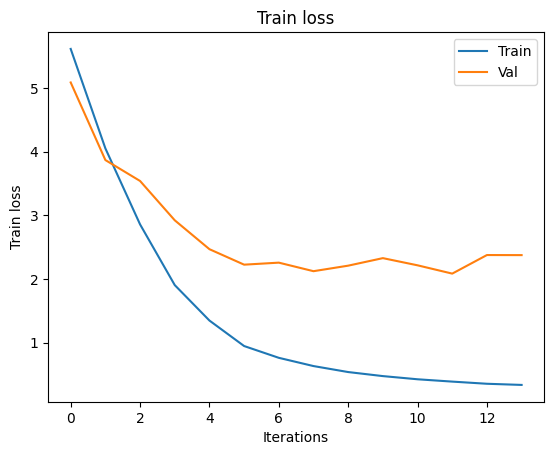

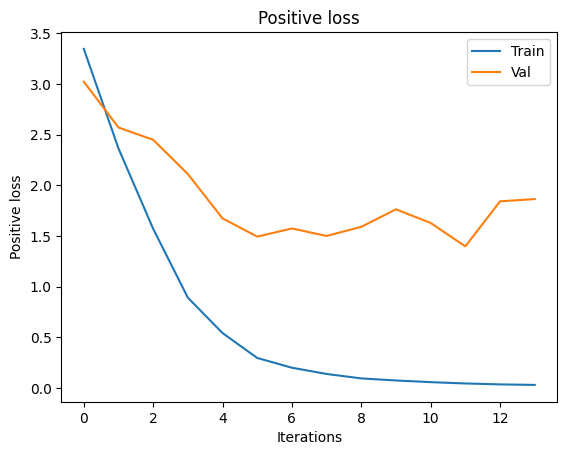

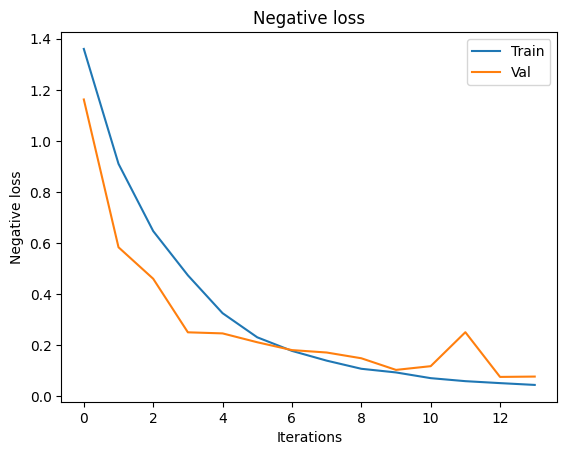

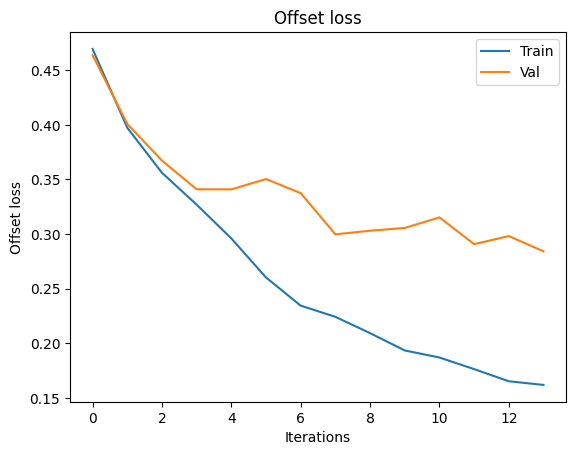

In [34]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

# Show predictions

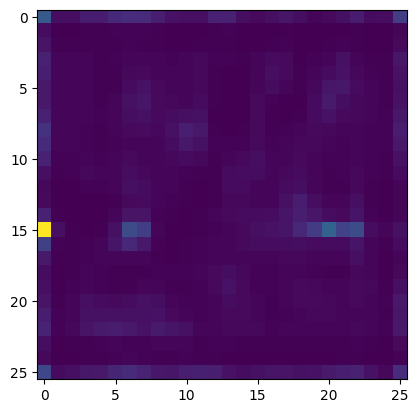

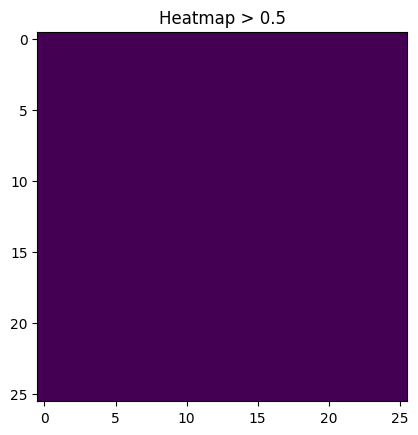

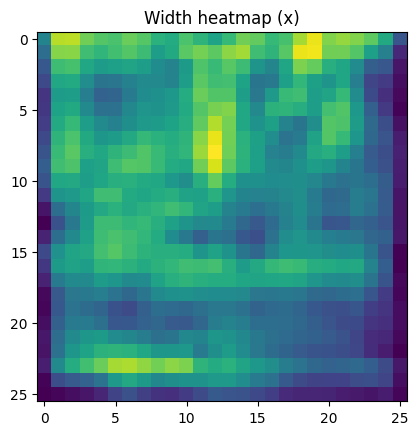

[]
[]


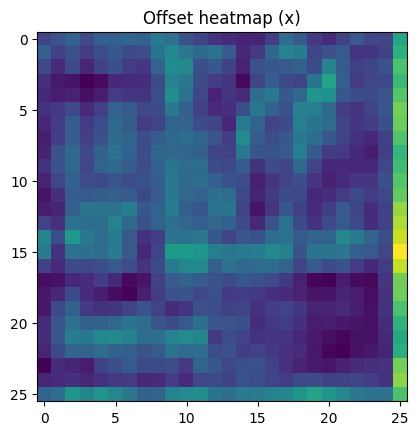

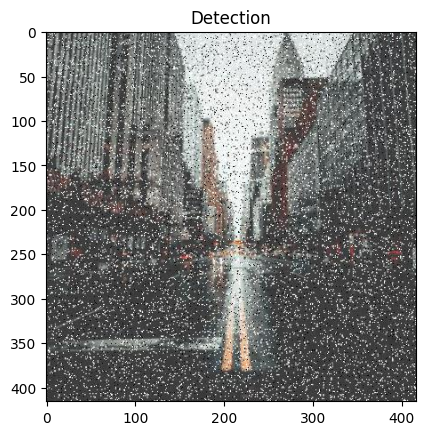

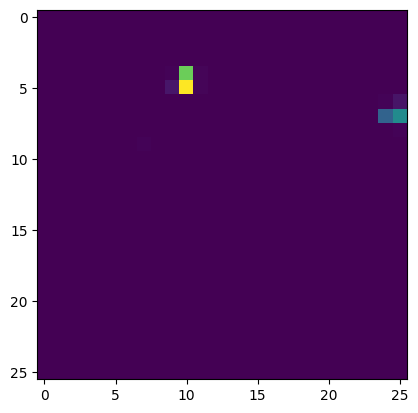

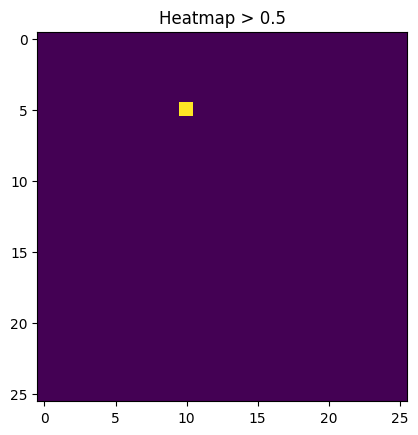

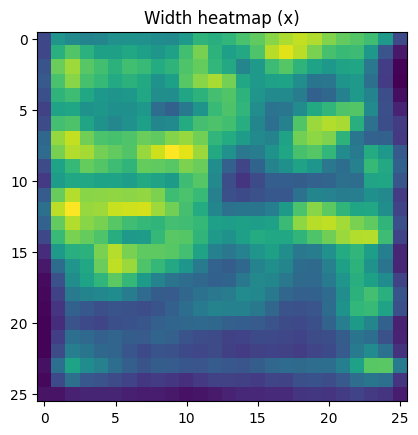

[[1.3099498 0.7825441]]
[[1.3099498]
 [0.7825441]]
[166, 82]


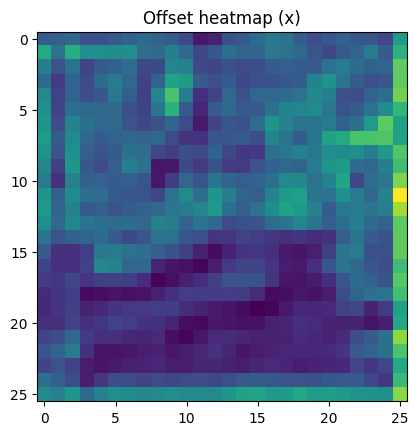

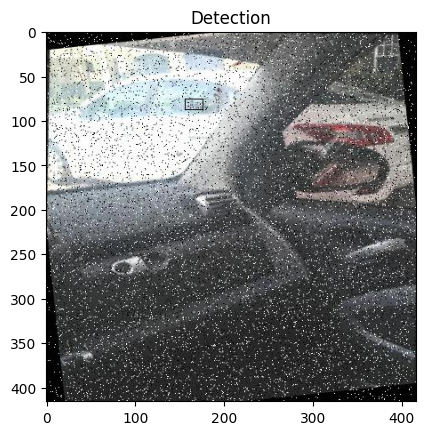

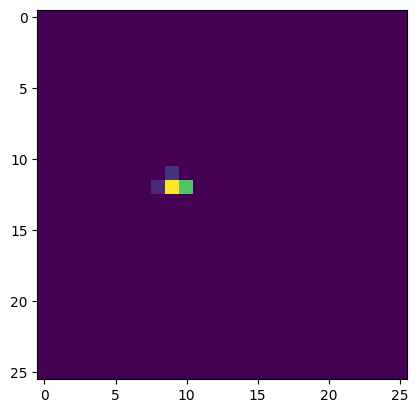

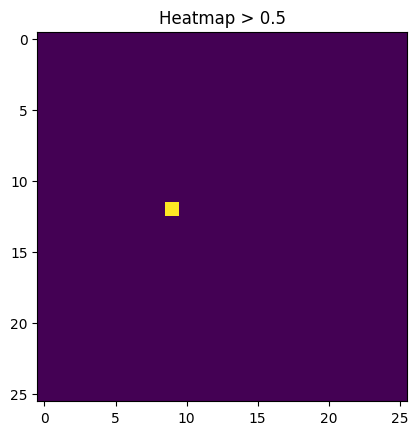

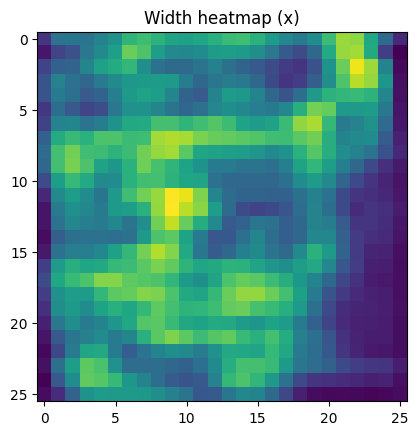

[[5.3794637 4.38355  ]]
[[5.3794637]
 [4.38355  ]]
[150, 195]


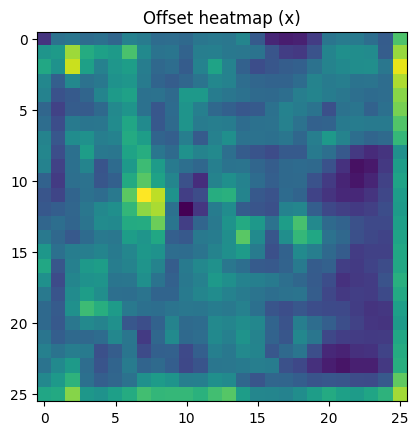

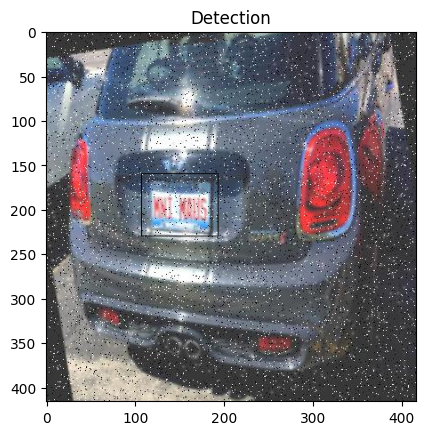

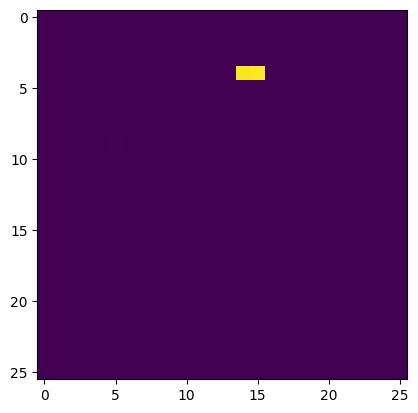

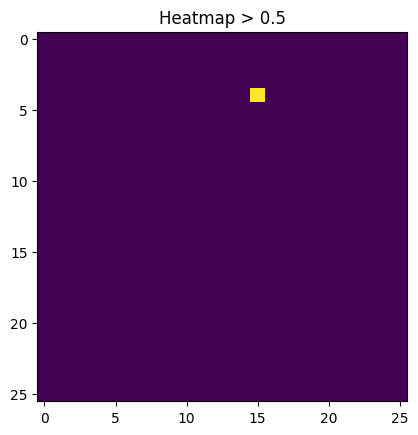

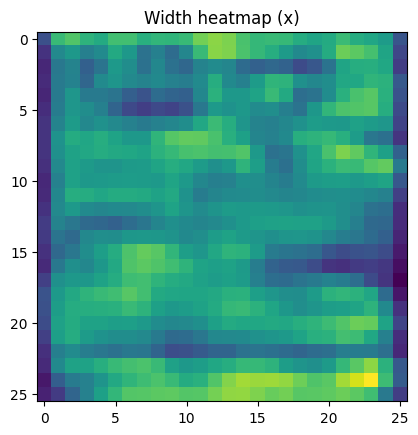

[[2.6112986 1.4318247]]
[[2.6112986]
 [1.4318247]]
[241, 71]


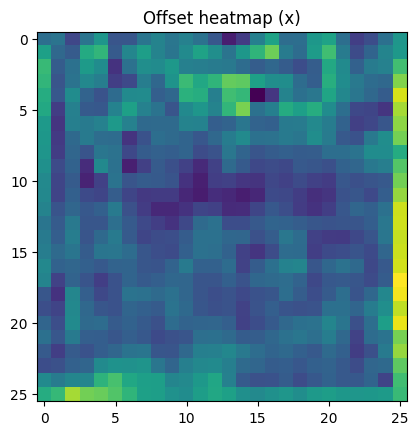

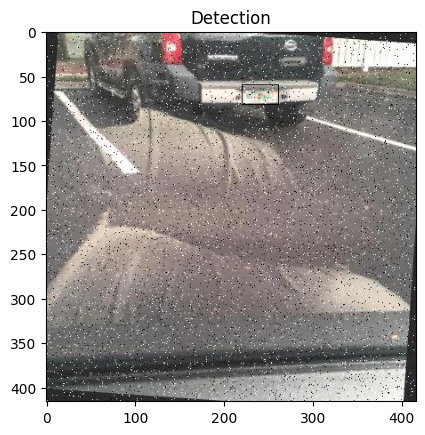

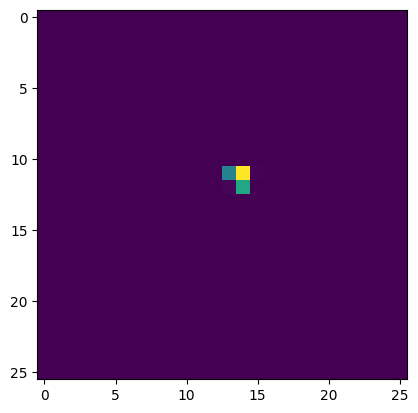

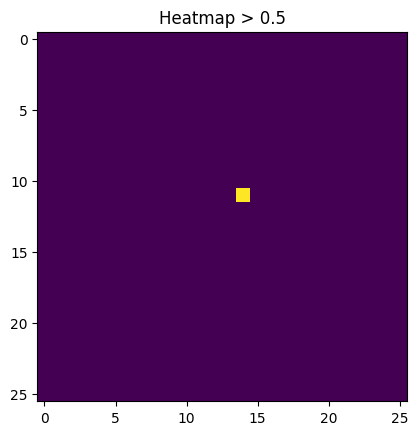

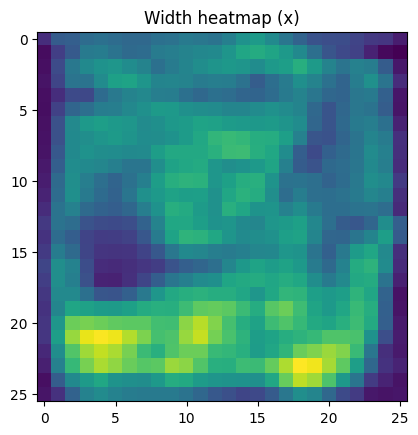

[[3.9765453 3.0240748]]
[[3.9765453]
 [3.0240748]]
[226, 187]


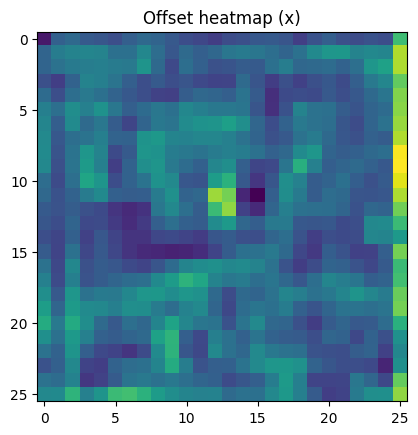

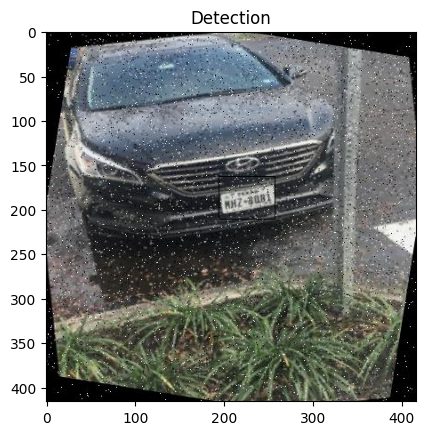

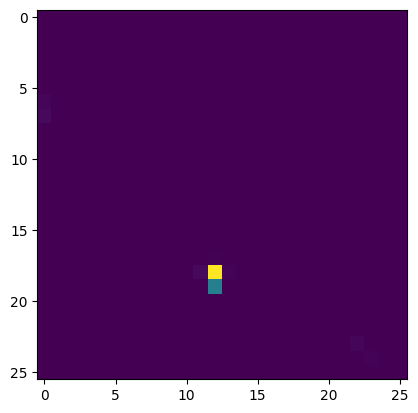

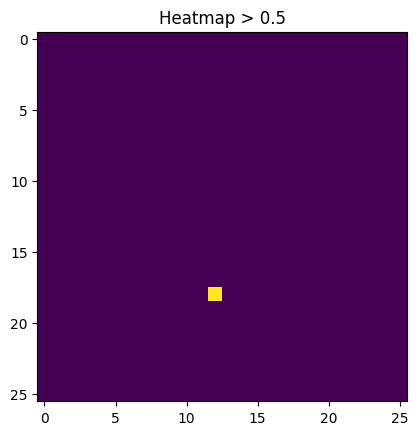

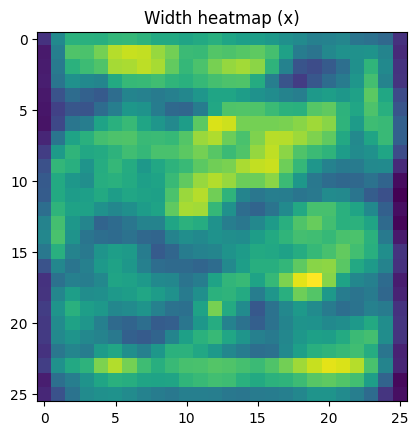

[[3.8802474 3.7500436]]
[[3.8802474]
 [3.7500436]]
[197, 298]


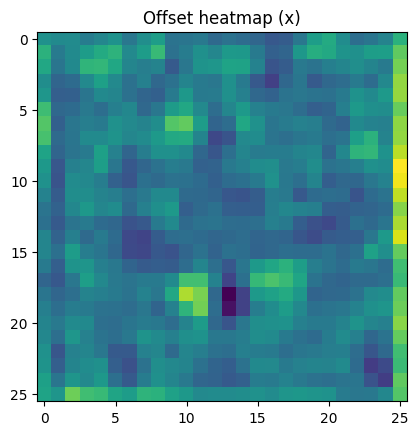

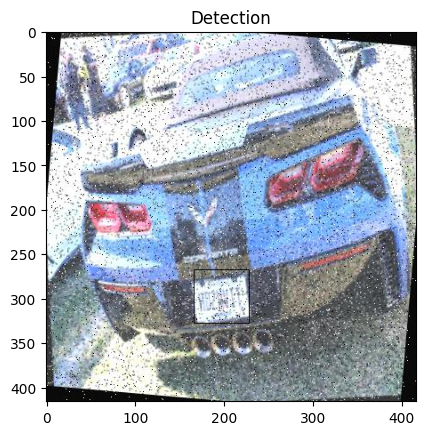

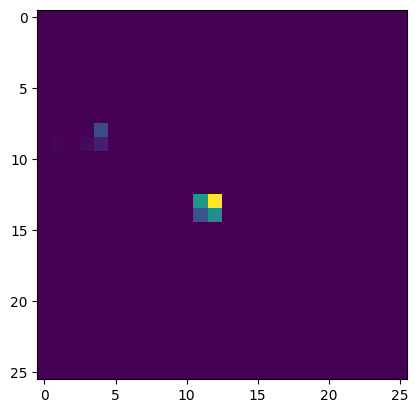

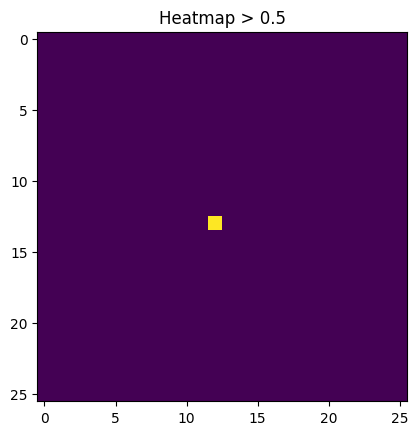

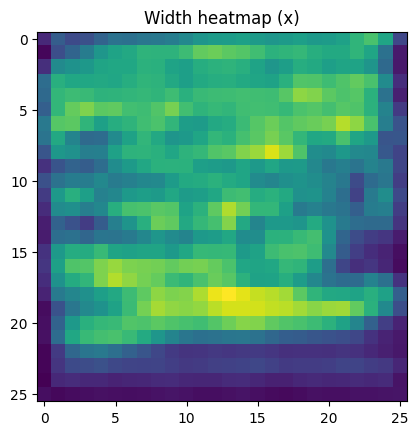

[[3.290494 2.344279]]
[[3.290494]
 [2.344279]]
[194, 221]


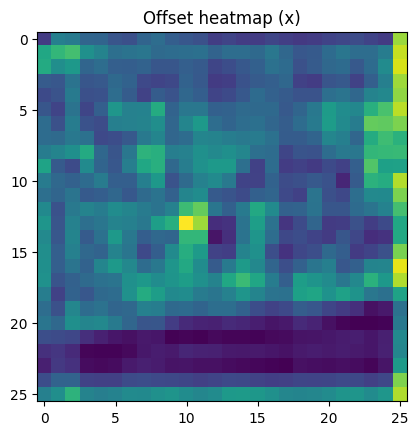

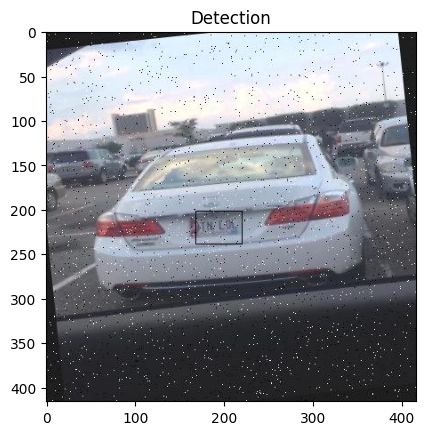

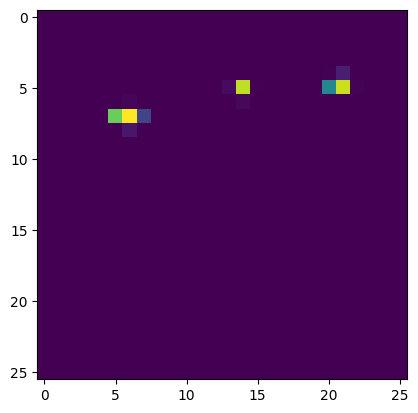

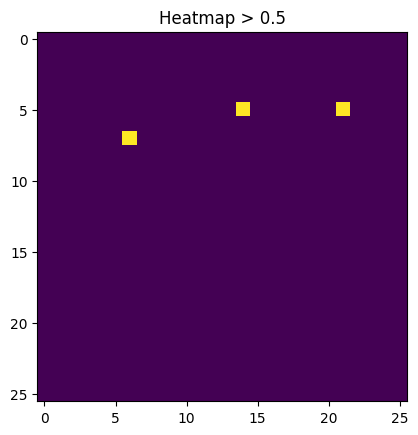

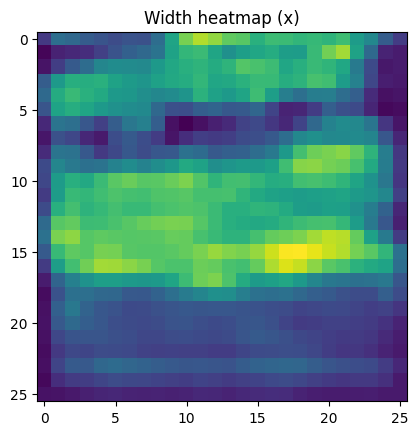

[[1.0141125  0.7714315 ]
 [0.7615425  0.14950481]
 [1.0211749  0.48141828]]
[[1.0141125  0.7615425  1.0211749 ]
 [0.7714315  0.14950481 0.48141828]]
[230, 90]
[336, 82]
[98, 119]


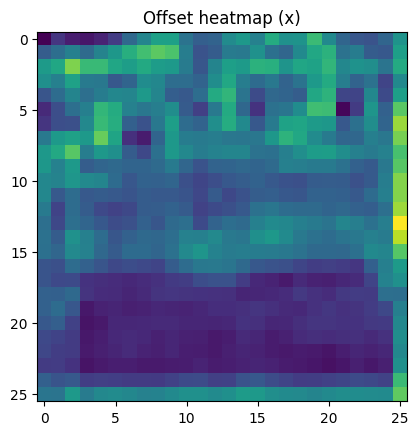

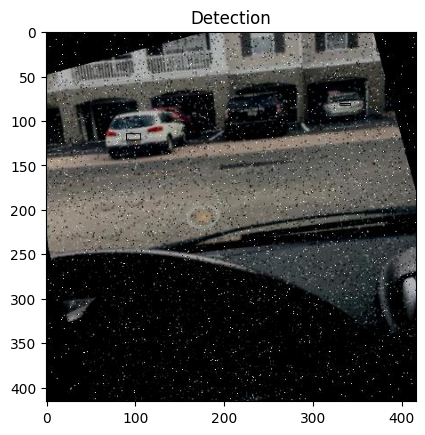

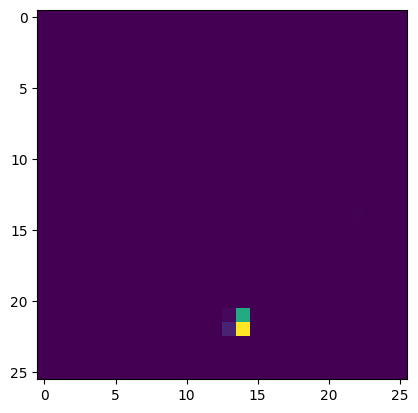

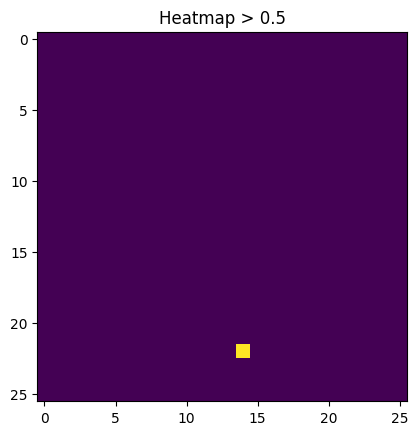

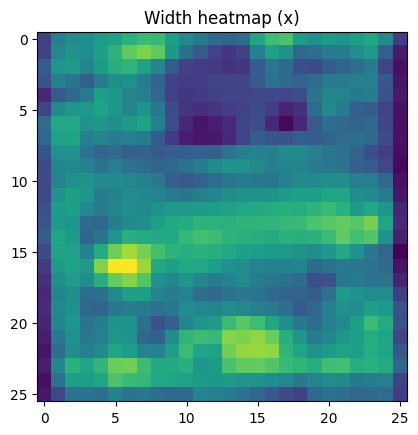

[[5.4851947 4.488512 ]]
[[5.4851947]
 [4.488512 ]]
[226, 351]


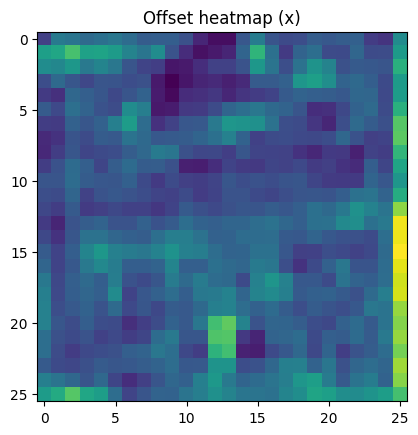

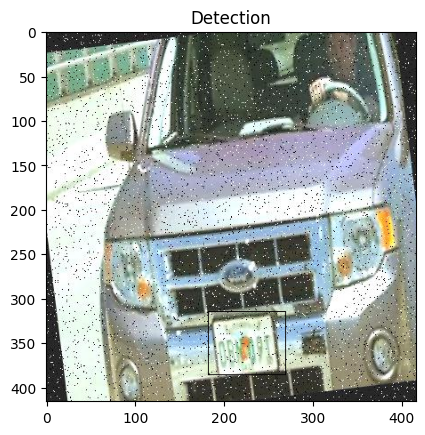

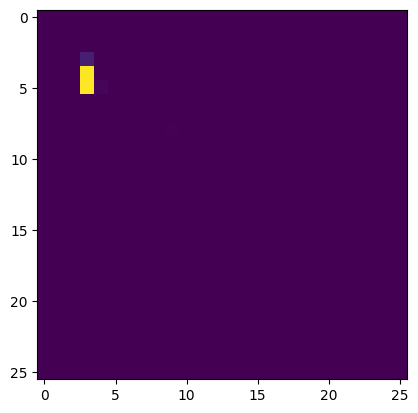

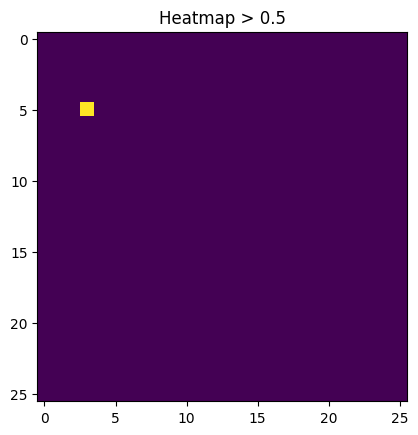

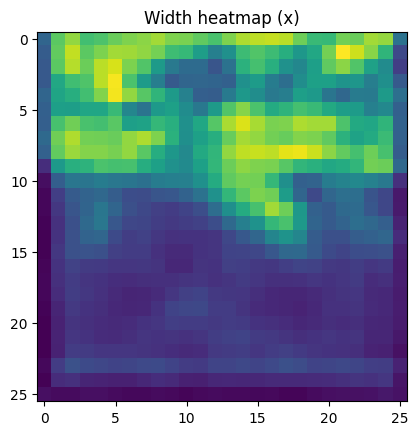

[[2.3320405 1.4118294]]
[[2.3320405]
 [1.4118294]]
[53, 79]


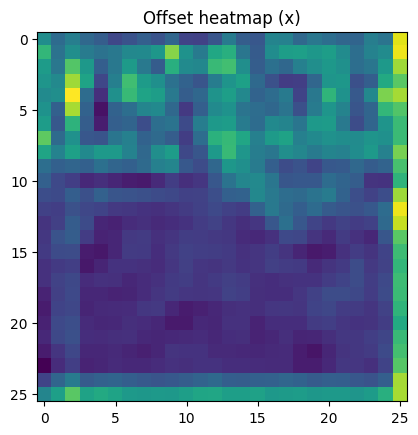

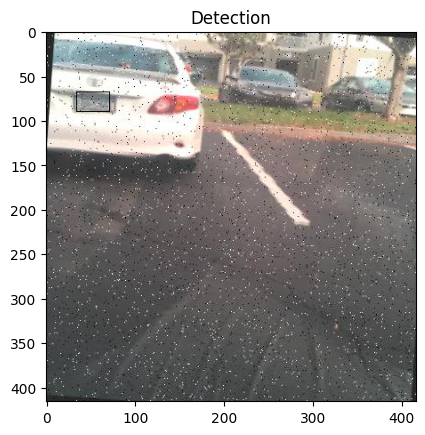

In [35]:
model.load_state_dict(torch.load("centernet-box-bbox_.pth"))
model.eval()

threshold = 0.5

for id in range(10):
    img, hm_gt, offset_gt, regr_gt = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh = model(img.to(device).float().unsqueeze(0))

    
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    #angle = angle.cpu().numpy().squeeze(0)
    
    #print(angle.shape)

    # show image
    img_id = test_id[id]
    img = cv2.imread(os.path.join(dataset_folder+"train", img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (input_size, input_size))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    plt.imshow(hm)
    plt.show()
    hm = select(hm, threshold)
    
    plt.imshow(hm>threshold)
    plt.title(f"Heatmap > {threshold}")
    plt.show()
    
    plt.imshow(wh[0])
    plt.title("Width heatmap (x)")
    plt.show()
    
    sample = showbox(img, hm, offset, wh, threshold)
    plt.imshow(offset[0])
    plt.title("Offset heatmap (x)")
    plt.show()
    
    
    # show gt
    #fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.title("Detection")
    plt.show()